In [6]:
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.qualitymetrics as sqm
import spikeinterface.widgets as sw
import spikeinterface.exporters as sexp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import glob

%matplotlib inline

#######################################################################
animal_ID = 'FNT098'
session_ID = '2024-03-11T11-24-46'

base_folder = r"W:\projects\FlexiVexi\behavioural_data"
session_folder = os.path.join(base_folder, animal_ID, session_ID)

#######################################################################

overwrite_sa=True

**Read in recording and spike sorting**

In [2]:
# Path to Kilosort3 output files within session folder
kilosort_folder = os.path.join(session_folder, 'kilosort3_v3')

# Get output from spike sorting using Kilosort3, keeping only good units
sorting_KS = se.read_kilosort(folder_path=kilosort_folder,keep_good_only=True)
print(sorting_KS)

# Get path to Open-Ephys Record Node within session folder
matching_files = glob.glob(os.path.join(session_folder, '**', 'settings.xml'), recursive=True)
if matching_files:
    # Get the first matching file
    first_matching_file = matching_files[0]
  
    # Get the directory of the first matching file
    path_to_recording = os.path.dirname(first_matching_file)
else:
    print("No 'settings.xml' file found in the specified path.")
    
# Get recording from open ephys
recording = se.read_openephys(folder_path=path_to_recording, stream_name = 'Record Node 102#Neuropix-PXI-100.ProbeA')

KiloSortSortingExtractor: 199 units - 1 segments - 30.0kHz


**Get sorting analyzer**

In [7]:
output_folder = os.path.join(session_folder, 'spikeinterface')
filename_sa = 'sorting_analyzer_'+session_ID+'.pkl'
filepath_sa = os.path.join(output_folder, filename_sa)

if glob.glob(filepath_sa) and overwrite_sa == False:
    sorting_analyzer = sc.load_sorting_analyzer(folder=filepath_sa)
    print('Sorting analyzer loaded from:', filepath_sa)
else:
    # Create a sorting analyzer
    sorting_analyzer = sc.create_sorting_analyzer(sorting_KS, recording)

    # Compute sorting analyzer info for main analysis
    sorting_analyzer.compute("random_spikes")
    sorting_analyzer.compute("waveforms")

    # Compute sorting analyzer info for quality metrics
    sorting_analyzer.compute("templates")
    sorting_analyzer.compute("noise_levels")
    sorting_analyzer.compute("principal_components")
    sorting_analyzer.get_extension('principal_components').get_data()  
    sorting_analyzer.get_extension('templates').get_data()

    # Save sorting analyzer to a .pkl file
    sorting_analyzer.save_as(folder=os.path.join(output_folder,filename_sa))
    print('Sorting analyzer saved to:', os.path.join(output_folder,filename_sa))

# Print sorting analyzer metadata
available_extension_names = sorting_analyzer.get_loaded_extension_names()
print(available_extension_names)

estimate_sparsity:   0%|          | 0/3475 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/3475 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/199 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/199 [00:00<?, ?it/s]

AttributeError: 'SortingAnalyzer' object has no attribute 'save'

In [10]:
## Load recording and sorting analyzer (if sorting analyzer it exists)

# Load recording from open ephys binary file
# Get path to Open-Ephys Record Node within session folder
matching_files = glob.glob(os.path.join(session_folder, '**', 'settings.xml'), recursive=True)
if matching_files:
    # Get the first matching file
    first_matching_file = matching_files[0]

    # Get the directory of the first matching file
    path_to_recording = os.path.dirname(first_matching_file)
else:
    print("No 'settings.xml' file found in the specified path.")
recording = se.read_openephys(folder_path=path_to_recording, stream_name = 'Record Node 102#Neuropix-PXI-100.ProbeA')

# Load sorting analyzer .pkl file
output_folder = os.path.join(session_folder, 'spikeinterface')
filename_sa = 'sorting_analyzer_'+session_ID+'.pkl'
path_to_sa = os.path.join(output_folder, filename_sa) 

sorting_analyzer = sc.load_sorting_analyzer(folder=filepath)
available_extension_names = sorting_analyzer.get_loaded_extension_names()
print(available_extension_names)

sorting_analyzer

['noise_levels', 'principal_components', 'quality_metrics', 'random_spikes', 'templates', 'waveforms']


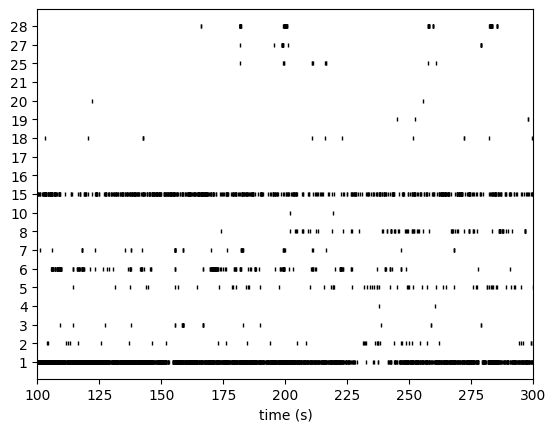

In [18]:
# Get all unit ids. If keep_good_only=True, only IDs of good units are returned
unit_ids = sorting_analyzer.unit_ids[:] 

# Plots rasters of first 20 units
w_rs = sw.plot_rasters(sorting_analyzer, time_range=(100, 300), unit_ids = unit_ids[1:20])

**Get recording metadata**

Sampling frequency: 30000.0
Number of channels: 384
Number of segments: 1
Probe - 384ch - 4shanks


(<matplotlib.collections.PolyCollection at 0x1cd4662ab40>,
 <matplotlib.collections.PolyCollection at 0x1cd466674d0>)

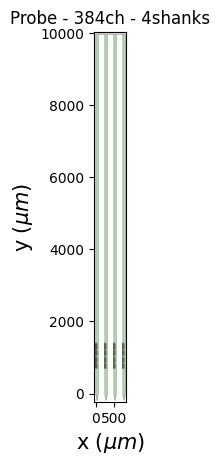

In [4]:
# Get basic meta-data from recording
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print("Sampling frequency:", fs)
print("Number of channels:", num_chan)
print("Number of segments:", num_seg)

probe = recording.get_probe()
print(probe)

from probeinterface.plotting import plot_probe

plot_probe(probe)

**Compute PCA and non-PCA metrics together**

In [19]:
# depends on "waveforms", "templates", "noise_levels", and "pca" (if computing pca metrics)
qm = sqm.compute_quality_metrics(sorting_analyzer, load_if_exists=None) 

# Save quality metrics to a .csv file
output_folder = os.path.join(session_folder, 'spikeinterface')
filename_qm = 'quality_metrics_v3_good_units_'+session_ID+'.csv'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
qm.to_csv(os.path.join(output_folder, filename_qm))

C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:880: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:724: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:1457: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(


calculate_pc_metrics:   0%|          | 0/199 [00:00<?, ?it/s]

PermissionError: [Errno 13] Permission denied: 'W:\\projects\\FlexiVexi\\behavioural_data\\FNT098\\2024-03-11T11-24-46\\spikeinterface\\quality_metrics_v3_good_units_2024-03-11T11-24-46.csv'

In [ ]:
# Save sorting analyzer to a .pkl file
output_folder = os.path.join(session_folder, 'spikeinterface')
filename_sa = 'sorting_analyzer_'+session_ID+'.pkl'
filepath = os.path.join(output_folder, filename_sa) 
sc.load_sorting_analyzer(folder=filepath)

**Get categorization of good versus bad units**

In [ ]:
# Get KS Labels
print(dir(se.KiloSortSortingExtractor))
print(se.KiloSortSortingExtractor.get_property_keys(sorting_KS))
help(se.KiloSortSortingExtractor.get_property)
KS_Labels = se.KiloSortSortingExtractor.get_property(sorting_KS, key='KSLabel')
cluster_IDs = se.KiloSortSortingExtractor.get_property(sorting_KS, key='original_cluster_id')

# Append KS_Labels to quality metrics

**Get signal quality metadata**

In [35]:
# get sorting metadata
num_units = se.KiloSortSortingExtractor.get_num_units(sorting_KS)
print(str(num_units) + ' units in sorting analyzer.')

num_spikes_per_unit = se.KiloSortSortingExtractor.count_num_spikes_per_unit(sorting_KS)
num_spikes_total = sum(num_spikes)
print(str(num_spikes_total) + ' spikes in sorting analyzer.')

# get QM metadata
l_ratio_average = qm['l_ratio'].mean()
l_ratio_median = qm['l_ratio'].median()
isolation_distance_average = qm['isolation_distance'].mean()
isolation_distance_median = qm['isolation_distance'].median()
d_prime_average = qm['d_prime'].mean()
d_prime_median = qm['d_prime'].median()

print('L-ratio average:', l_ratio_average)
print('L-ratio median:', l_ratio_median)
print('Isolation distance average:', isolation_distance_average)
print('Isolation distance median:', isolation_distance_median)
print('D-prime average:', d_prime_average)
print('D-prime median:', d_prime_median)

199 units in sorting analyzer.
35339 spikes in sorting analyzer.
L-ratio average: 6.711641021129618
L-ratio median: 8.656063280979758
Isolation distance average: 287736473182.91016
Isolation distance median: 119.4447966314515
D-prime average: 0.8059389818917121
D-prime median: 0.719629915526518


In [47]:
help(se.KiloSortSortingExtractor.load_metadata_from_folder)

Help on function load_metadata_from_folder in module spikeinterface.core.base:

load_metadata_from_folder(self, folder_metadata)



**Analyse Units**

In [20]:
unit_locations = sorting_analyzer.compute(input="unit_locations", method="monopolar_triangulation")


**Export sorting analyser to Phy**

In [13]:
sexp.export_to_phy(sorting_analyzer, "phy", verbose=True)